<a href="https://colab.research.google.com/github/evmpython/CAT212_2025/blob/main/CAT212_Aula_06_Mapa_relampagos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Disciplina:** CAT212 - Microfísica de Nuvens e Eletricidade Atmosférica
---

## 🟢 **Aula Prática 6:** $\underline{Criando\ Mapas\ de\ Relâmpagos}$

---


**OBJETIVO:**
 - Nesta aula prática aprenderemos como criar mapas da densidade de relâmpagos (relâmpagos/km$^{2}$). Para isto utilizaremos os dados de relâmpagos da rede [Earth Networks Total Lightning Network (ENTLN)](https://www.earthnetworks.com/why-us/networks/lightning/). Para mais informações sobre a ENTLN clique [aqui](https://www.earthnetworks.com/Portals/0/pdf/ENTLN%20Global%20Slick_v4).



---



**DADOS DE ENTRADA**:

Arquivos texto de relâmpagos.

- **Tipo do dado:** tabela  
- **Formato do dado:** arquivo TEXTO
- **Nome do arquivo:** pulse_CLIMATE_2020-01-01.txt.gz
- **Fonte dos dados:** Rede EarthNetwork, cedido para fins didáticos pela CLIMATEMPO



---

**DADOS DE SAÍDA:**
- **Tipo do dado:** Figuras, arquivos netcdf e tabelas
- **Formato do dado:** arquivo PNG, NETCDF e TXT
- **Imagens geradas:**
    1. Fig_1_relampagos_mes.png
    2. Fig_2_anual.png
    3. Fig_3_mensal.jpg
    4. raios_2018-01-01.nc
    5. raios.txt



---

**PROCEDIMENTO REALIZADO:**
 - Nessa aula realizaremos os seguintes procedimentos:

    1.   Instalação das bibliotecas
    2.   Importação das bibliotecas
    3.   Montando drive
    4.   Definindo o caminho do diretório
    5.   Declarando funções
    6.   Carregando shapefiles
    7.   Destargeando os arquivos
    8.   Informações da matriz de raios
    9.   Plotar mapa para um determinado mês
    10.  Pré-tratamento dos dados
    11.  Plotar mapa de acumulado de relâmpagos para um ano
    12.  Plotar mapa de acumulado mensal de relâmpagos para um ano
    13.  Salvar os dados em arquivo ASCII

  

---



**OBSERVAÇÕES IMPORTANTES**:
1. Mudar o caminho para o seu drive.
2. Escolha o Estado para qual será produzido o mapa.

---
**PROFESSOR:**

 - Enrique Vieira Mattos - UNIFEI: enrique@unifei.edu.br / https://github.com/evmpython
 - Atualizado em: 11/04/2025


---


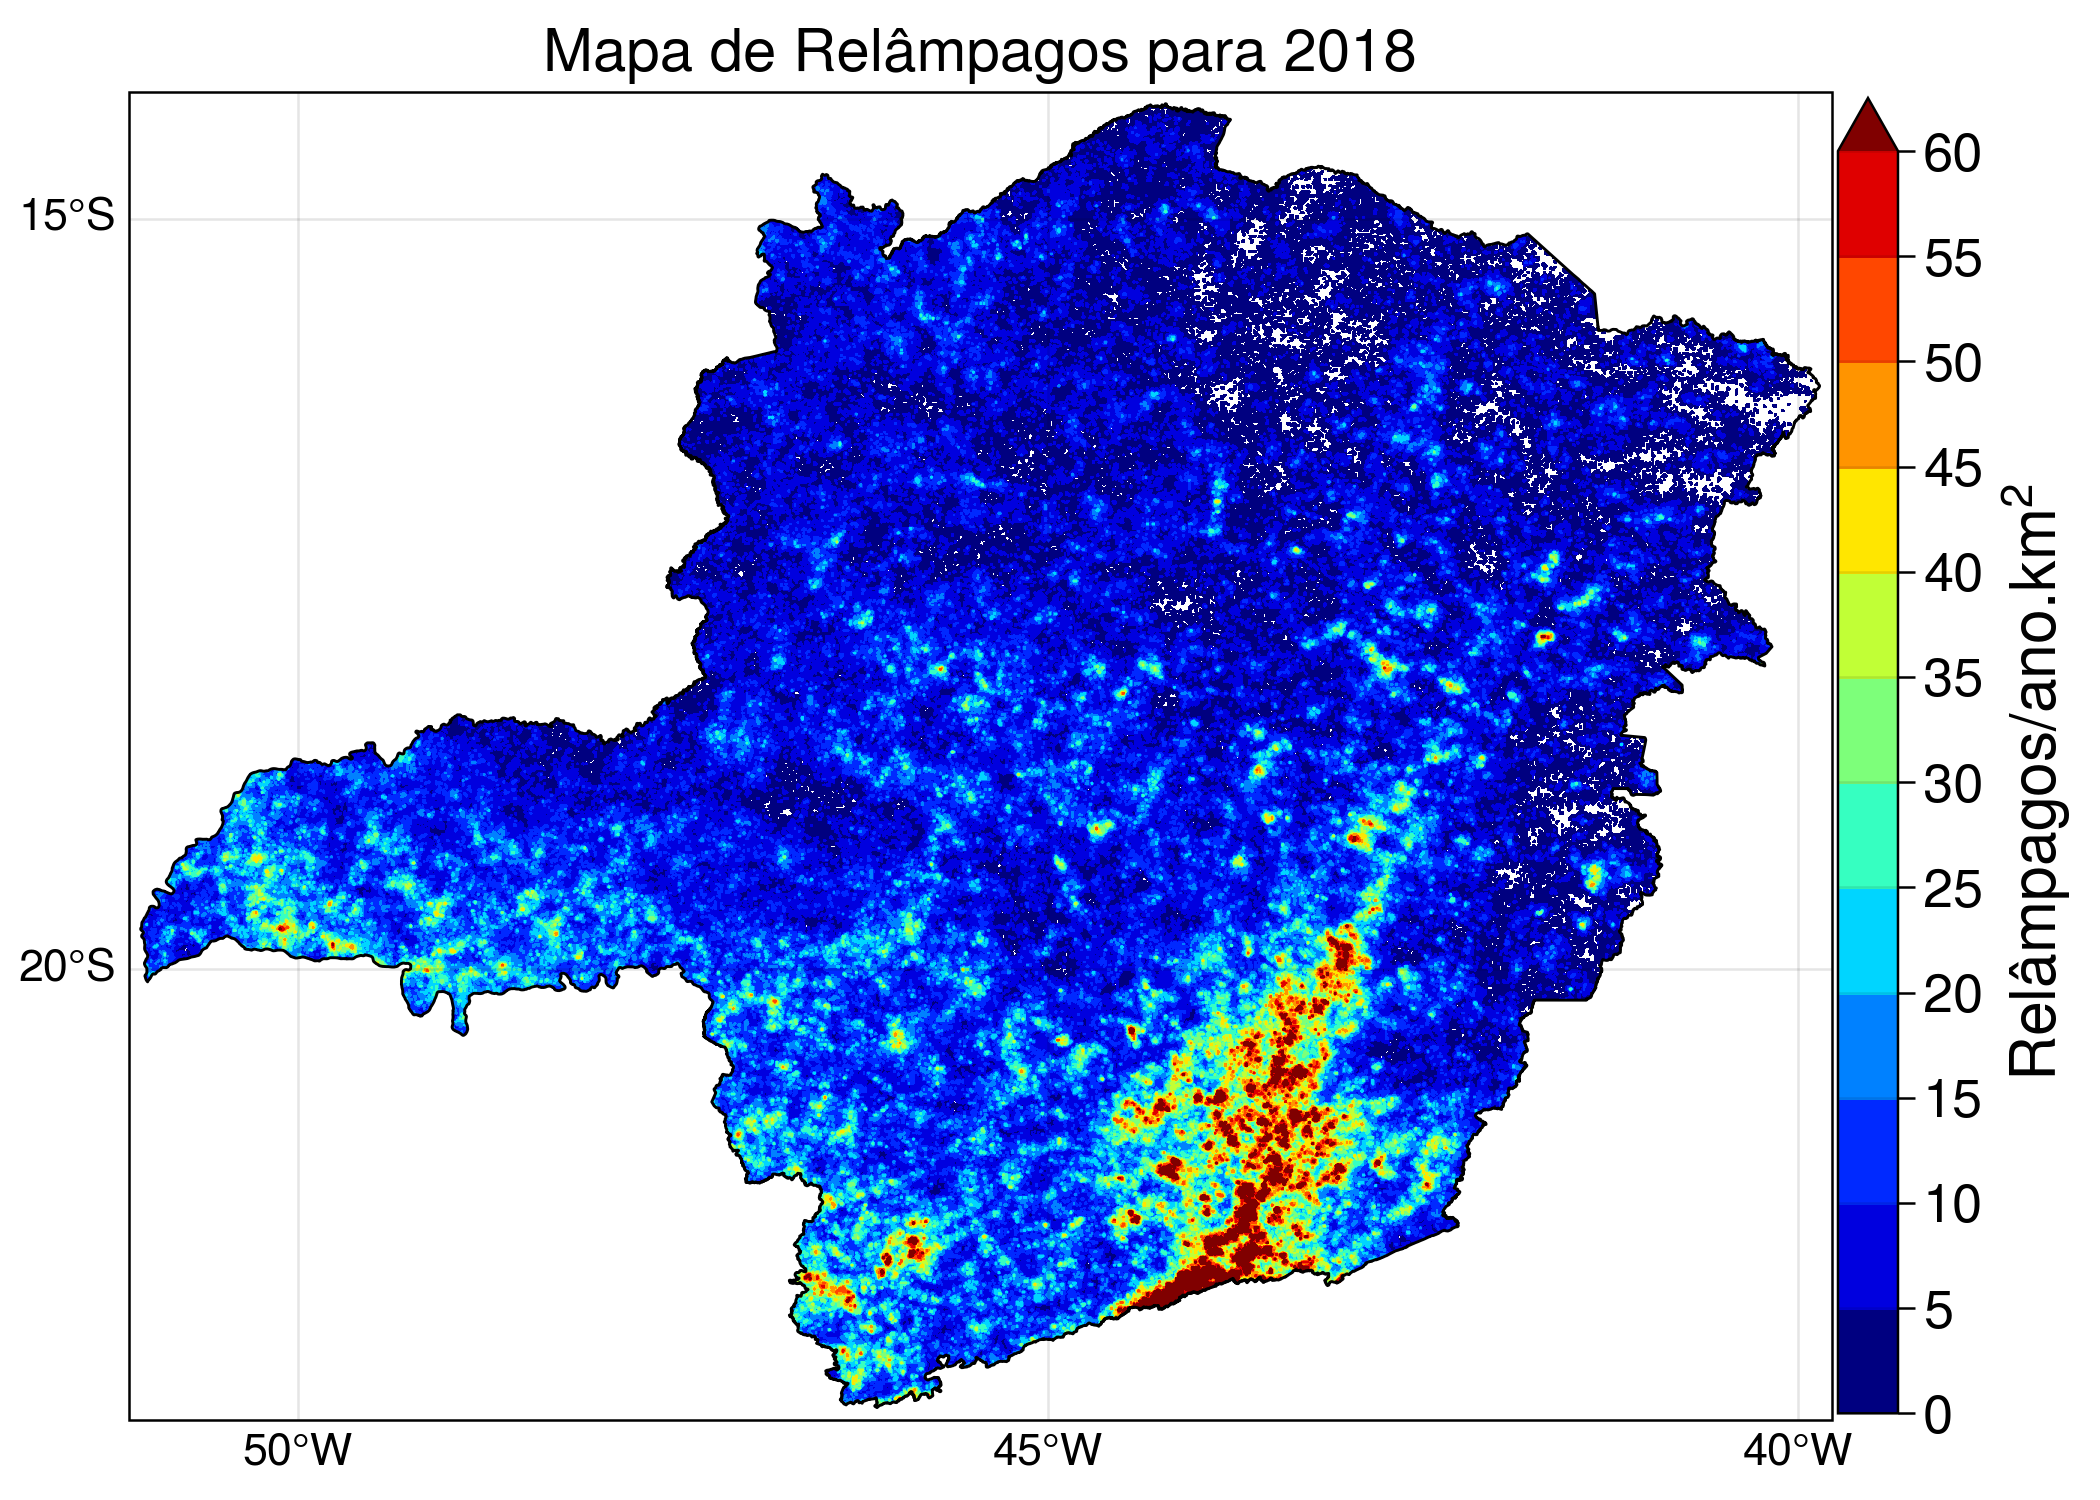

# **1° Passo:** Instalando as bibliotecas

In [1]:
!pip install -q ultraplot cartopy salem rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.0 MB/s eta 0:00:00


# **2° Passo:** Importando as bibliotecas

In [3]:
import numpy as np                          # Biblioteca para trabalhar com matrizes
import pandas as pd                         # Biblioteca para trabalhar com tabelas (parecidas com tabelas em excel)
import ultraplot as uplt                    # Biblioteca para gerar figuras
import os                                   # Biblioteca para acessar o sistema operacional
import cartopy.crs as ccrs                  # Biblioteca para trabalhar com projeções de mapas
import cartopy.io.shapereader as shpreader  # Biblioteca para ler arquivos shapefiles
import tarfile                              # Biblioteca para destargear um arquivo
from tqdm.notebook import tqdm_notebook     # Biblioteca que cira barra de progresso
import salem                                # Biblioteca para mascarar regiões
import xarray as xr                         # Biblioteca para para ler/criar arquivos netcdf
import glob                                 # Biblioteca para para listar arquivos
import calendar                             # Biblioteca para calendário
import time                                 # Biblioteca de contagem de tempo

# vamos ignorar vários avisos
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/ultraplot/__init__.py:77: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


# **3° Passo:** Montando drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **4° Passo:** Caminho do diretório - **### >>> MUDANÇAS AQUI <<< ###**

- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula: `alterar aqui`

In [5]:
dir = '/content/drive/MyDrive/00_DISPONIBILIZAÇÃO_DE_AULAS/1_PRIMEIRO_SEMESTRE/CAT212 - MICROFÍSICA DE NUVENS E ELETRICIDADE ATMOSFÉRICA/AULAS/CAT212 - PYTHON PARA MICROFISICA DE NUVENS/AULA_06_RELAMPAGOS_MAPAS'

- **Criando a pasta de saída ("output")**

In [37]:
os.makedirs(f'{dir}/output/', exist_ok=True)
os.makedirs(f'/content/txt/', exist_ok=True)
os.makedirs(f'/content/netcdf/', exist_ok=True)

# **5° Passo:** Declara função

##**Função que calcula o índice i e j da localização do relâmpago**

In [7]:
# Função que calcula o índice i e j da localização do relâmpago
def index(longitudes_matriz, latitudes_matriz, lon_raio, lat_raio):

    ''' Função para calcular o índice (i e j) do pixel de uma matriz que o relâmpago pertence

    Parâmetros:
               longitudes_matriz (array): array de uma dimensão das longitudes da matriz em graus
               latitudes_matriz (array): array de uma dimensão das latitudes da matriz em graus
               lon_raio (float): valor da longitude do relâmpago em graus
               lat_raio (float): valor da latitude do relâmpago em graus

    Retorna:
            indice_lat_raio (float): índice da latitude (ou seja, da linha) do pixel da matriz que o relâmpago pertence
            indice_lon_raio (float): índice da longitude (ou seja, da coluna) do pixel da matriz que o relâmpago pertence
    '''

    # calcula a diferença entre as lats/lons da matriz e a latitude/longitude do relâmpago
    distancia_lon = (longitudes_matriz - lon_raio)**2
    distancia_lat = (latitudes_matriz - lat_raio)**2

    # índice da longitude e latitude do relâmpago
    indice_lon_raio = np.nonzero(distancia_lon == np.min(distancia_lon))
    indice_lat_raio = np.nonzero(distancia_lat == np.min(distancia_lat))

    # retorna os valores dos índices calculados
    return indice_lat_raio, indice_lon_raio

# **6° Passo:** Shapefiles - **### >>> MUDANÇAS AQUI <<< ###**


- Iremos utilizar os arquivos shapefiles do território brasileiro. Os dados serão baixados direto do meu [GitHub](https://github.com/evmpython/shapefile).

In [8]:
#--------------------------------------------------------------#
#                  SHAPEFILES DO ESTADO
#--------------------------------------------------------------#
# sigla do Estado
# escolha o Estado. Lembre de escolher apenas entre os Estados da região Sudeste: SP, RJ, MG, ES
sigla_estado = 'MG'

# url do github
url =  'https://github.com/evmpython/shapefile/raw/main/UFs/'

# nomes completos dos arquivos
file1 = f'{url}{sigla_estado}/{sigla_estado}_UF_2019.cpg'
file2 = f'{url}{sigla_estado}/{sigla_estado}_UF_2019.dbf'
file3 = f'{url}{sigla_estado}/{sigla_estado}_UF_2019.prj'
file4 = f'{url}{sigla_estado}/{sigla_estado}_UF_2019.shp'
file5 = f'{url}{sigla_estado}/{sigla_estado}_UF_2019.shx'

# baixa o shapefile
!wget -c {file1} # 'https://github.com/evmpython/shapefile/raw/main/UFs/AC/AC_UF_2019.shp
!wget -c {file2}
!wget -c {file3}
!wget -c {file4}
!wget -c {file5}

# lendo shapefile de todos Estados do Brasil
estado = salem.read_shapefile(f'/content/{sigla_estado}_UF_2019.shp')

# designa os limites do Estado
lonmin, lonmax, latmin, latmax = float(estado['min_x']), float(estado['max_x']), float(estado['min_y']), float(estado['max_y'])

# exibe os limites do shapefile
print(lonmin, lonmax, latmin, latmax )

--2025-04-11 21:44:40--  https://github.com/evmpython/shapefile/raw/main/UFs/MG/MG_UF_2019.cpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/evmpython/shapefile/main/UFs/MG/MG_UF_2019.cpg [following]
--2025-04-11 21:44:40--  https://raw.githubusercontent.com/evmpython/shapefile/main/UFs/MG/MG_UF_2019.cpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5 [text/plain]
Saving to: ‘MG_UF_2019.cpg’

MG_UF_2019.cpg      100%[===================>]       5  --.-KB/s    in 0s      

2025-04-11 21:44:40 (101 KB/s) - ‘MG_UF_2019.cpg’ saved [5/5]

--2025-04-11 21:44:40--  https://github.com/evmpython/shap

#**PARTE 1:** Destargeando o arquivo de relâmpagos


- São arquivos de relâmpagos para o ano de 2018, separados por dia. Após destargeados eles serão salvos no Drive na pasta `/content/txt`.

In [9]:
%%time
# Caminho onde o arquivo .tar.gz está localizado
input_path = f'{dir}/input/pulse_CLIMATE_2018.tar.gz'

# Caminho onde os arquivos extraídos serão salvos
output_path = f'/content/txt'

# Abrir o arquivo tar.gz
tar = tarfile.open(input_path)

# Listar os nomes dos arquivos dentro do tar
tar.getnames()

# Extrair todos os arquivos para o caminho desejado
tar.extractall(path=output_path)

# Fechar o arquivo tar
tar.close()

CPU times: user 21.8 s, sys: 3.72 s, total: 25.6 s
Wall time: 38.3 s


#**PARTE 2:** Informações da matriz de raios

In [10]:
# Configuração da grade
#lonmin = -51.3
#lonmax = -39.7
#latmin = -23.0
#latmax = -14.0

# Espaçamento da grade
delta = 0.01   # grade com 1 km de resolução espacial

# Montando a grade
lons = np.arange(lonmin, lonmax, delta)
lats = np.arange(latmax, latmin, -delta)

# Quantidade de pontos para longitude e latitude
nlon = len(lons)
nlat = len(lats)

In [11]:
lats

array([-14.23318067, -14.24318067, -14.25318067, -14.26318067,
       -14.27318067, -14.28318067, -14.29318067, -14.30318067,
       -14.31318067, -14.32318067, -14.33318067, -14.34318067,
       -14.35318067, -14.36318067, -14.37318067, -14.38318067,
       -14.39318067, -14.40318067, -14.41318067, -14.42318067,
       -14.43318067, -14.44318067, -14.45318067, -14.46318067,
       -14.47318067, -14.48318067, -14.49318067, -14.50318067,
       -14.51318067, -14.52318067, -14.53318067, -14.54318067,
       -14.55318067, -14.56318067, -14.57318067, -14.58318067,
       -14.59318067, -14.60318067, -14.61318067, -14.62318067,
       -14.63318067, -14.64318067, -14.65318067, -14.66318067,
       -14.67318067, -14.68318067, -14.69318067, -14.70318067,
       -14.71318067, -14.72318067, -14.73318067, -14.74318067,
       -14.75318067, -14.76318067, -14.77318067, -14.78318067,
       -14.79318067, -14.80318067, -14.81318067, -14.82318067,
       -14.83318067, -14.84318067, -14.85318067, -14.86

In [12]:
lons

array([-51.04608181, -51.03608181, -51.02608181, ..., -39.88608181,
       -39.87608181, -39.86608181])

In [13]:
nlon

1119

In [14]:
nlat

869

#**PARTE 3:** Mapa para um determinado mês

**Selecionando o mês de janeiro**

In [ ]:
# mês escolhido
mes = 1

# nome por extenso dos meses
nome_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho',
              'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# monta lista dos arquivos daquele mês
files = sorted(glob.glob(f'/content/txt/pulse_CLIMATE_2018-{str(mes).zfill(2)}*.txt.gz')) # /content/txt/pulse_CLIMATE_2018-01-01.txt.gz

# mostra a lista de arquivos
files

**Leitura do dado**

In [ ]:
%%time
# Cria uma lista vazia
df_list = []

# Loop dos arquivos por dia
for file in tqdm_notebook(files):

    print('PROCESSANDO === >>>:', file)

    # Leitura do arquivo
    df0 = pd.read_csv(file, delimiter='\s+', compression='gzip', usecols=['tipo','ano','mes','dia','hor','min','seg','lat','lon','pc(A)'])

    # Seleciona os relâmpagos dentro do Estado escolhido
    df1 = df0[ (df0['lon'] > lonmin) & (df0['lon'] < lonmax) & (df0['lat'] > latmin) & (df0['lat'] < latmax)]

    # Insere a tabela numa lista
    df_list.append(df1)

# Junta todas as tabelas em uma única tabela
df = pd.concat(df_list, ignore_index=True)

**Mostrando o dado**

In [42]:
df.head()

,tipo,ano,mes,dia,hor,min,seg,lat,lon,pc(A)
0,CG,2018,1,1,0,0,2.0,-20.71509,-40.21806,-51697
1,CG,2018,1,1,0,0,2.0,-20.69931,-40.21913,-36453
2,CG,2018,1,1,0,0,3.0,-20.71385,-40.20418,-28250
3,IC,2018,1,1,0,0,3.0,-20.67055,-40.06668,-3063
4,IC,2018,1,1,0,0,4.0,-19.47083,-40.63881,-4930


In [43]:
df.tail()

,tipo,ano,mes,dia,hor,min,seg,lat,lon,pc(A)
1661131,CG,2018,1,31,23,59,27.0,-17.64676,-46.13549,100018
1661132,CG,2018,1,31,23,59,27.0,-17.64640,-46.13330,21256
1661133,IC,2018,1,31,23,59,27.0,-17.66833,-46.15732,-6078
1661134,IC,2018,1,31,23,59,51.0,-14.66031,-41.14596,-4860
1661135,CG,2018,1,31,23,59,51.0,-14.64796,-41.13064,-19819


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661136 entries, 0 to 1661135
Data columns (total 10 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   tipo    1661136 non-null  object 
 1   ano     1661136 non-null  int64  
 2   mes     1661136 non-null  int64  
 3   dia     1661136 non-null  int64  
 4   hor     1661136 non-null  int64  
 5   min     1661136 non-null  int64  
 6   seg     1661136 non-null  float64
 7   lat     1661136 non-null  float64
 8   lon     1661136 non-null  float64
 9   pc(A)   1661136 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 126.7+ MB


**Calculando os raios por ponto de grade**

In [45]:
%%time
# Transforma de series para numpy.array
raios_lon, raios_lat = df['lon'].values, df['lat'].values

CPU times: user 78 µs, sys: 2 µs, total: 80 µs
Wall time: 84.4 µs


In [46]:
# Declara a matriz de relâmpagos
raios = np.zeros((nlat, nlon))  # Exemplo: raios = np.zeros(qte_linha, qte_coluna)

In [47]:
%%time
# Loop em cada longitude e latitude da lista
for lonraio, latraio in zip(raios_lon, raios_lat):

    # função que extrai a qual pixel (ou seja, determina as variáveis 'lin' e 'col') aquele relâmpago pertence
    lin, col = index(lons, lats, lonraio, latraio)

    # soma os relâmpagos por pixel
    raios[lin,col]+=1

    """
    Exemplo:
      raios[2, 4] = 1
      raios[2, 4] = 2 (1+1)
      raios[2, 4] = 3 (2+1)
    """

CPU times: user 1min 15s, sys: 217 ms, total: 1min 15s
Wall time: 1min 20s


**Transforma a matriz para Xarray.DataSet**

In [48]:
data_vars = {'raio':(('lat', 'lon'), raios, {'units': 'ocorrências/km²', 'long_name':'Raios'})}
coords = {'lat': lats, 'lon': lons}
ds = xr.Dataset(data_vars=data_vars, coords=coords)

In [49]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 869, lon: 1119)
Coordinates:
  * lat      (lat) float64 7kB -14.23 -14.24 -14.25 ... -22.89 -22.9 -22.91
  * lon      (lon) float64 9kB -51.05 -51.04 -51.03 ... -39.89 -39.88 -39.87
Data variables:
    raio     (lat, lon) float64 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

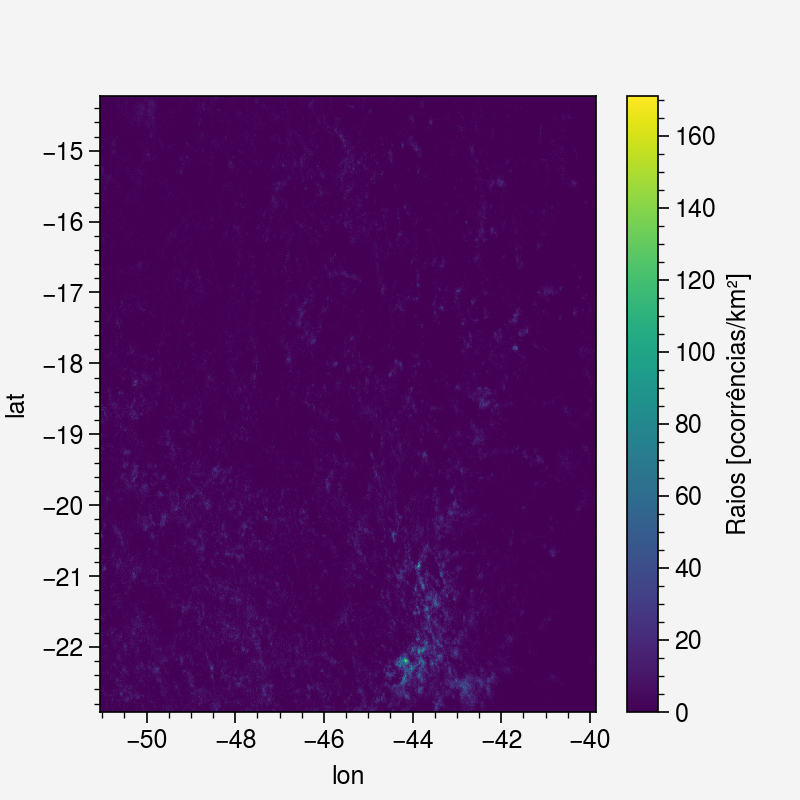

In [50]:
ds['raio'].plot()

**Plota figura**

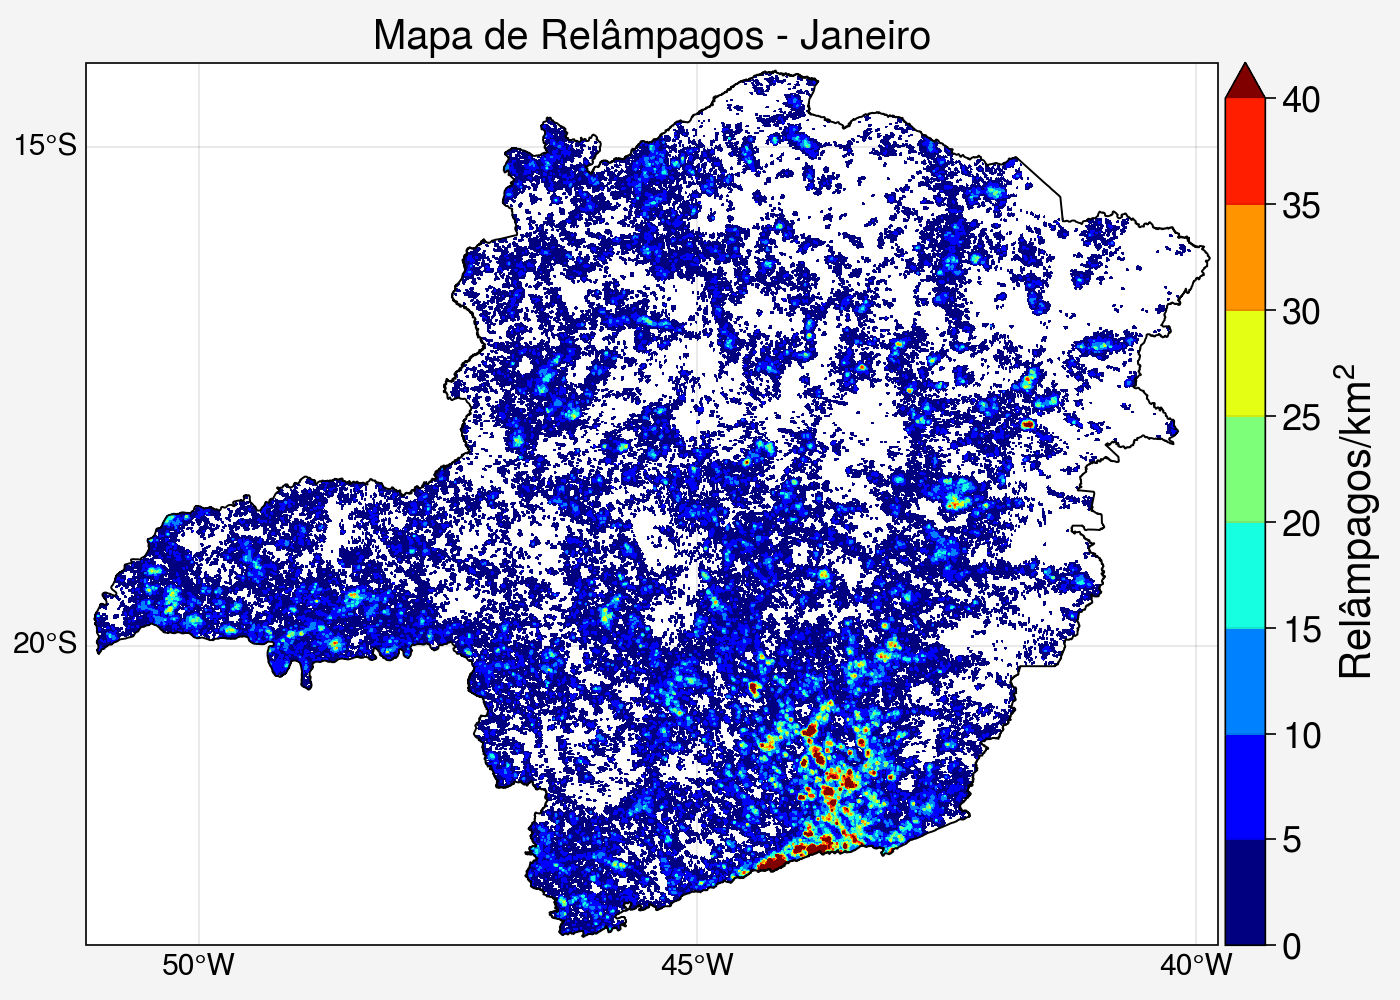

CPU times: user 4.05 s, sys: 36.2 ms, total: 4.08 s
Wall time: 5.61 s


In [53]:
%%time
# moldura da figura
fig, ax = uplt.subplots(figsize=(7,5), tight=True, proj='pcarree')

# fomatação dos eixos da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=5, lonlines=5,
          latlim=(latmin-0.08, latmax+0.08), lonlim=(lonmin-0.08, lonmax+0.08),
          title=f'Mapa de Relâmpagos - {nome_meses[mes-1]}',
          small='15px', large='20px', abc=False)

# substituir zeros por NaN na variável 'raio'
ds['raio'] = ds['raio'].where(ds['raio'] != 0, np.nan)

# plota figura
map1 = ax.contourf(ds['lon'],
                   ds['lat'],
                   ds['raio'].salem.roi(shape=estado),
                   cmap='jet',
                   vmin=0,
                   vmax=60,
                   levels=uplt.arange(0, 40, 5),
                   extend='max')

# adiciona shapefile do Estado
shapefile=list(shpreader.Reader(f'/content/{sigla_estado}_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.7)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Relâmpagos/km$^{2}$', length=0.97, ticklabelsize=13, labelsize=15, space=0.3)

# salva figura
fig.save(f'{dir}/output/Fig_1_relampagos_mes_{nome_meses[mes-1]}_{sigla_estado}.png', dpi=300)

# exibe na tela
uplt.show()

#**PARTE 4:** Pré-Tratamento dos dados para a `Parte 5, 6 e 7`

**Gera arquivos Netcdf por dia**.
- Esta etapa demora 11 min para processar.

In [27]:
%%time
# Loop dos arquivos por dia
for file in tqdm_notebook(sorted(glob.glob('/content/txt/pulse*.txt.gz'))):

    # imprime na tela o nome do arquivo
    print('PROCESSANDO === >>>:', file)

    # Leitura do arquivo com o Pandas
    df0 = pd.read_csv(file, delimiter='\s+', compression='gzip', usecols=['tipo','ano','mes','dia','hor','min','seg','lat','lon','pc(A)'])

    # Seleciona os relâmpagos dentro do Estado de MG
    tabela2 = df0[ (df0['lon'] > lonmin) & (df0['lon'] < lonmax) & (df0['lat'] > latmin) & (df0['lat'] < latmax)]

    # Gera matriz de raios
    raios_lon, raios_lat = tabela2['lon'].values, tabela2['lat'].values

    # Interpolando para ponto de grade
    raios = np.zeros((nlat, nlon))

    # Loop em cada longitude e latitude da lista
    for lonraio, latraio in zip(raios_lon, raios_lat):

        # função que extrai a qual pixel aquele relâmpago pertence
        lin, col = index(lons, lats, lonraio, latraio)

        # soma os relâmpagos por pixel
        raios[lin,col]+=1

    # Gera arquivo netcdf
    data_vars = {'raio':(('lat', 'lon'), raios, {'units': 'ocorrências/km²', 'long_name':'Raios'})}
    coords = {'lat': lats, 'lon': lons, 'time': pd.to_datetime(f'{file[27:37]}')}
    ds = xr.Dataset(data_vars=data_vars, coords=coords)
    ds.to_netcdf(f'/content/netcdf/raios_{file[27:37]}.nc')

  0%|          | 0/365 [00:00<?, ?it/s]

PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-01.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-02.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-03.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-04.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-05.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-06.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-07.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-08.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-09.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-10.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-11.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-12.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-13.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-14.txt.gz
PROCESSANDO === >>>: /content/txt/pulse_CLIMATE_2018-01-15.txt.gz
PROCESSAND

**Leitura dos arquivos netcdfs**.


In [28]:
dados = xr.open_mfdataset(f'/content/netcdf/raios*.nc', concat_dim='time', combine='nested')
dados

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 365, lat: 869, lon: 1119)
Coordinates:
  * lat      (lat) float64 7kB -14.23 -14.24 -14.25 ... -22.89 -22.9 -22.91
  * lon      (lon) float64 9kB -51.05 -51.04 -51.03 ... -39.89 -39.88 -39.87
  * time     (time) datetime64[ns] 3kB 2018-01-01 2018-01-02 ... 2018-12-31
Data variables:
    raio     (time, lat, lon) float64 3GB dask.array<chunksize=(1, 869, 1119), meta=np.ndarray>

**Agrupamento dos dados por Ano e por Mês**

In [29]:
# ANUAL
anual = dados.resample(time='1Y').sum() # ou anual = dados.groupby('time.year').sum('time')
anual

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 1, lat: 869, lon: 1119)
Coordinates:
  * lat      (lat) float64 7kB -14.23 -14.24 -14.25 ... -22.89 -22.9 -22.91
  * lon      (lon) float64 9kB -51.05 -51.04 -51.03 ... -39.89 -39.88 -39.87
  * time     (time) datetime64[ns] 8B 2018-12-31
Data variables:
    raio     (time, lat, lon) float64 8MB dask.array<chunksize=(1, 869, 1119), meta=np.ndarray>

In [30]:
# MENSAL
mensal = dados.resample(time='1M').sum() # ou mensal = dados.groupby('time.month').sum('time')
mensal

<xarray.Dataset> Size: 93MB
Dimensions:  (time: 12, lat: 869, lon: 1119)
Coordinates:
  * lat      (lat) float64 7kB -14.23 -14.24 -14.25 ... -22.89 -22.9 -22.91
  * lon      (lon) float64 9kB -51.05 -51.04 -51.03 ... -39.89 -39.88 -39.87
  * time     (time) datetime64[ns] 96B 2018-01-31 2018-02-28 ... 2018-12-31
Data variables:
    raio     (time, lat, lon) float64 93MB dask.array<chunksize=(1, 869, 1119), meta=np.ndarray>

#**PARTE 5:** Mapa Anual

**Mostrando a variável**

In [31]:
anual

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 1, lat: 869, lon: 1119)
Coordinates:
  * lat      (lat) float64 7kB -14.23 -14.24 -14.25 ... -22.89 -22.9 -22.91
  * lon      (lon) float64 9kB -51.05 -51.04 -51.03 ... -39.89 -39.88 -39.87
  * time     (time) datetime64[ns] 8B 2018-12-31
Data variables:
    raio     (time, lat, lon) float64 8MB dask.array<chunksize=(1, 869, 1119), meta=np.ndarray>

**Plota a figura**

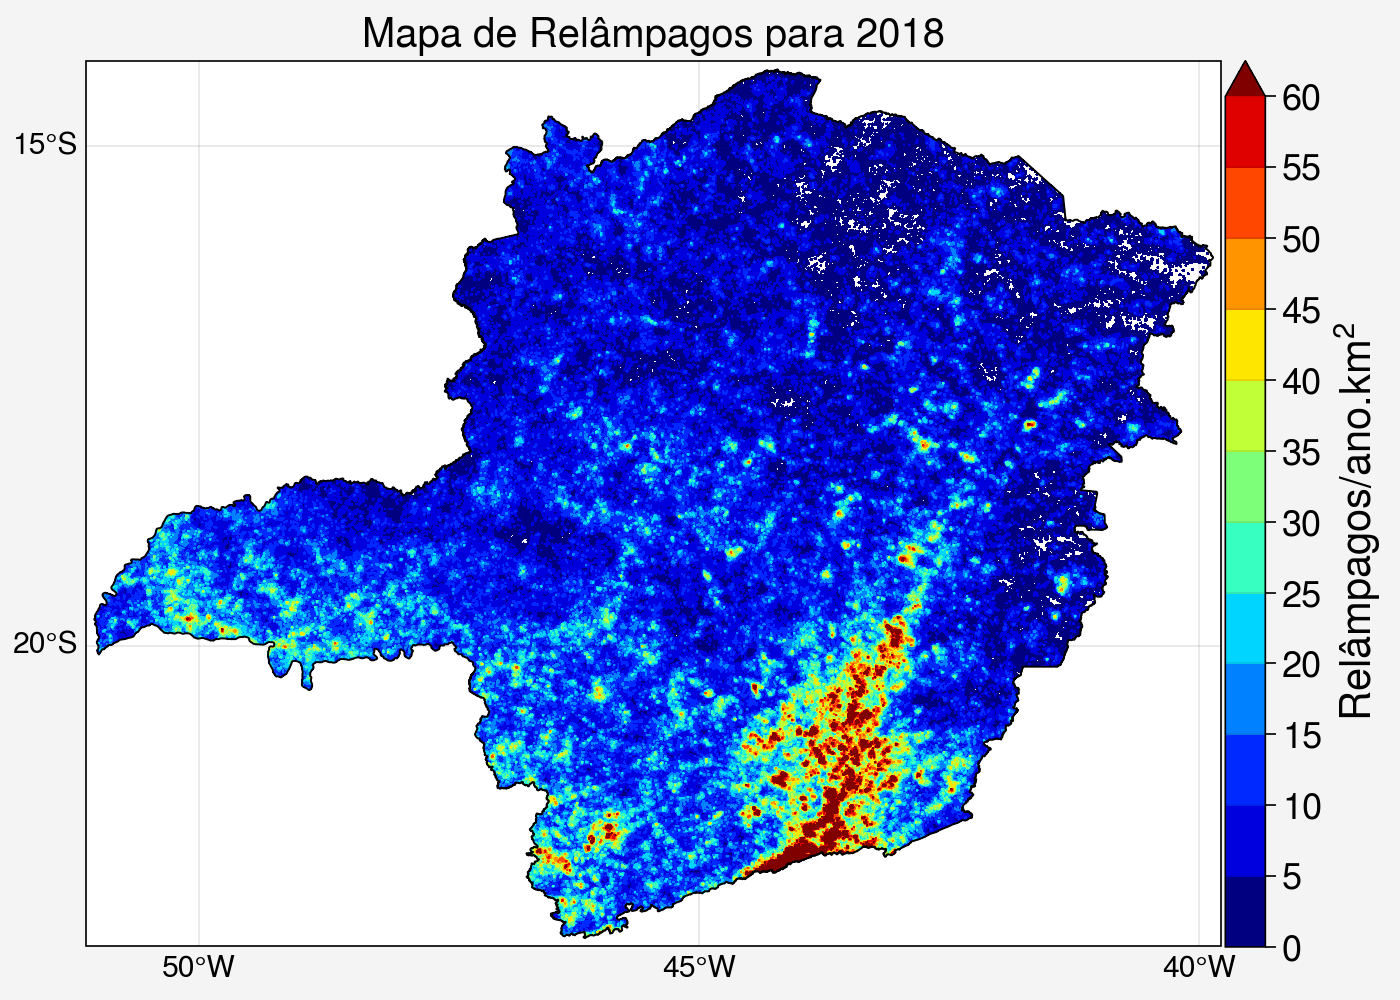

In [57]:
# moldura da figura
fig, ax = uplt.subplots(figsize=(7,5), tight=True, proj='pcarree')

# fomatação dos eixos da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=5, lonlines=5,
          latlim=(latmin-0.08, latmax+0.08), lonlim=(lonmin-0.08, lonmax+0.08),
          title=f'Mapa de Relâmpagos para 2018',
          small='15px', large='20px', abc=False)

# substituir zeros por NaN na variável 'raio'
anual['raio'] = anual['raio'].where(anual['raio'] != 0, np.nan)

# plota figura
map1 = ax.contourf(anual['lon'],
                   anual['lat'],
                   anual['raio'][0,:,:].salem.roi(shape=estado),
                   cmap='jet',
                   vmin=0,
                   vmax=60,
                   levels=uplt.arange(0, 60, 5),
                   extend='max')

# adiciona shapeFile de MG
shapefile=list(shpreader.Reader(f'/content/{sigla_estado}_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.7)

# plota barra de cores da figura
fig.colorbar(map1, loc='r', label='Relâmpagos/ano.km$^{2}$', length=0.98, ticklabelsize=13, labelsize=15, space=0.17)

# salva figura
fig.save(f'{dir}/output/Fig_2_relampagos_total_anual_{sigla_estado}.png', dpi=300)

# exibe na tela
uplt.show()

#**PARTE 6:** Mapa mensal

**Mostrando a variável**

In [33]:
mensal

<xarray.Dataset> Size: 93MB
Dimensions:  (time: 12, lat: 869, lon: 1119)
Coordinates:
  * lat      (lat) float64 7kB -14.23 -14.24 -14.25 ... -22.89 -22.9 -22.91
  * lon      (lon) float64 9kB -51.05 -51.04 -51.03 ... -39.89 -39.88 -39.87
  * time     (time) datetime64[ns] 96B 2018-01-31 2018-02-28 ... 2018-12-31
Data variables:
    raio     (time, lat, lon) float64 93MB dask.array<chunksize=(1, 869, 1119), meta=np.ndarray>

**Plotando a figura**

Processando o mês: .... 0
Processando o mês: .... 1
Processando o mês: .... 2
Processando o mês: .... 3
Processando o mês: .... 4
Processando o mês: .... 5
Processando o mês: .... 6
Processando o mês: .... 7
Processando o mês: .... 8
Processando o mês: .... 9
Processando o mês: .... 10
Processando o mês: .... 11


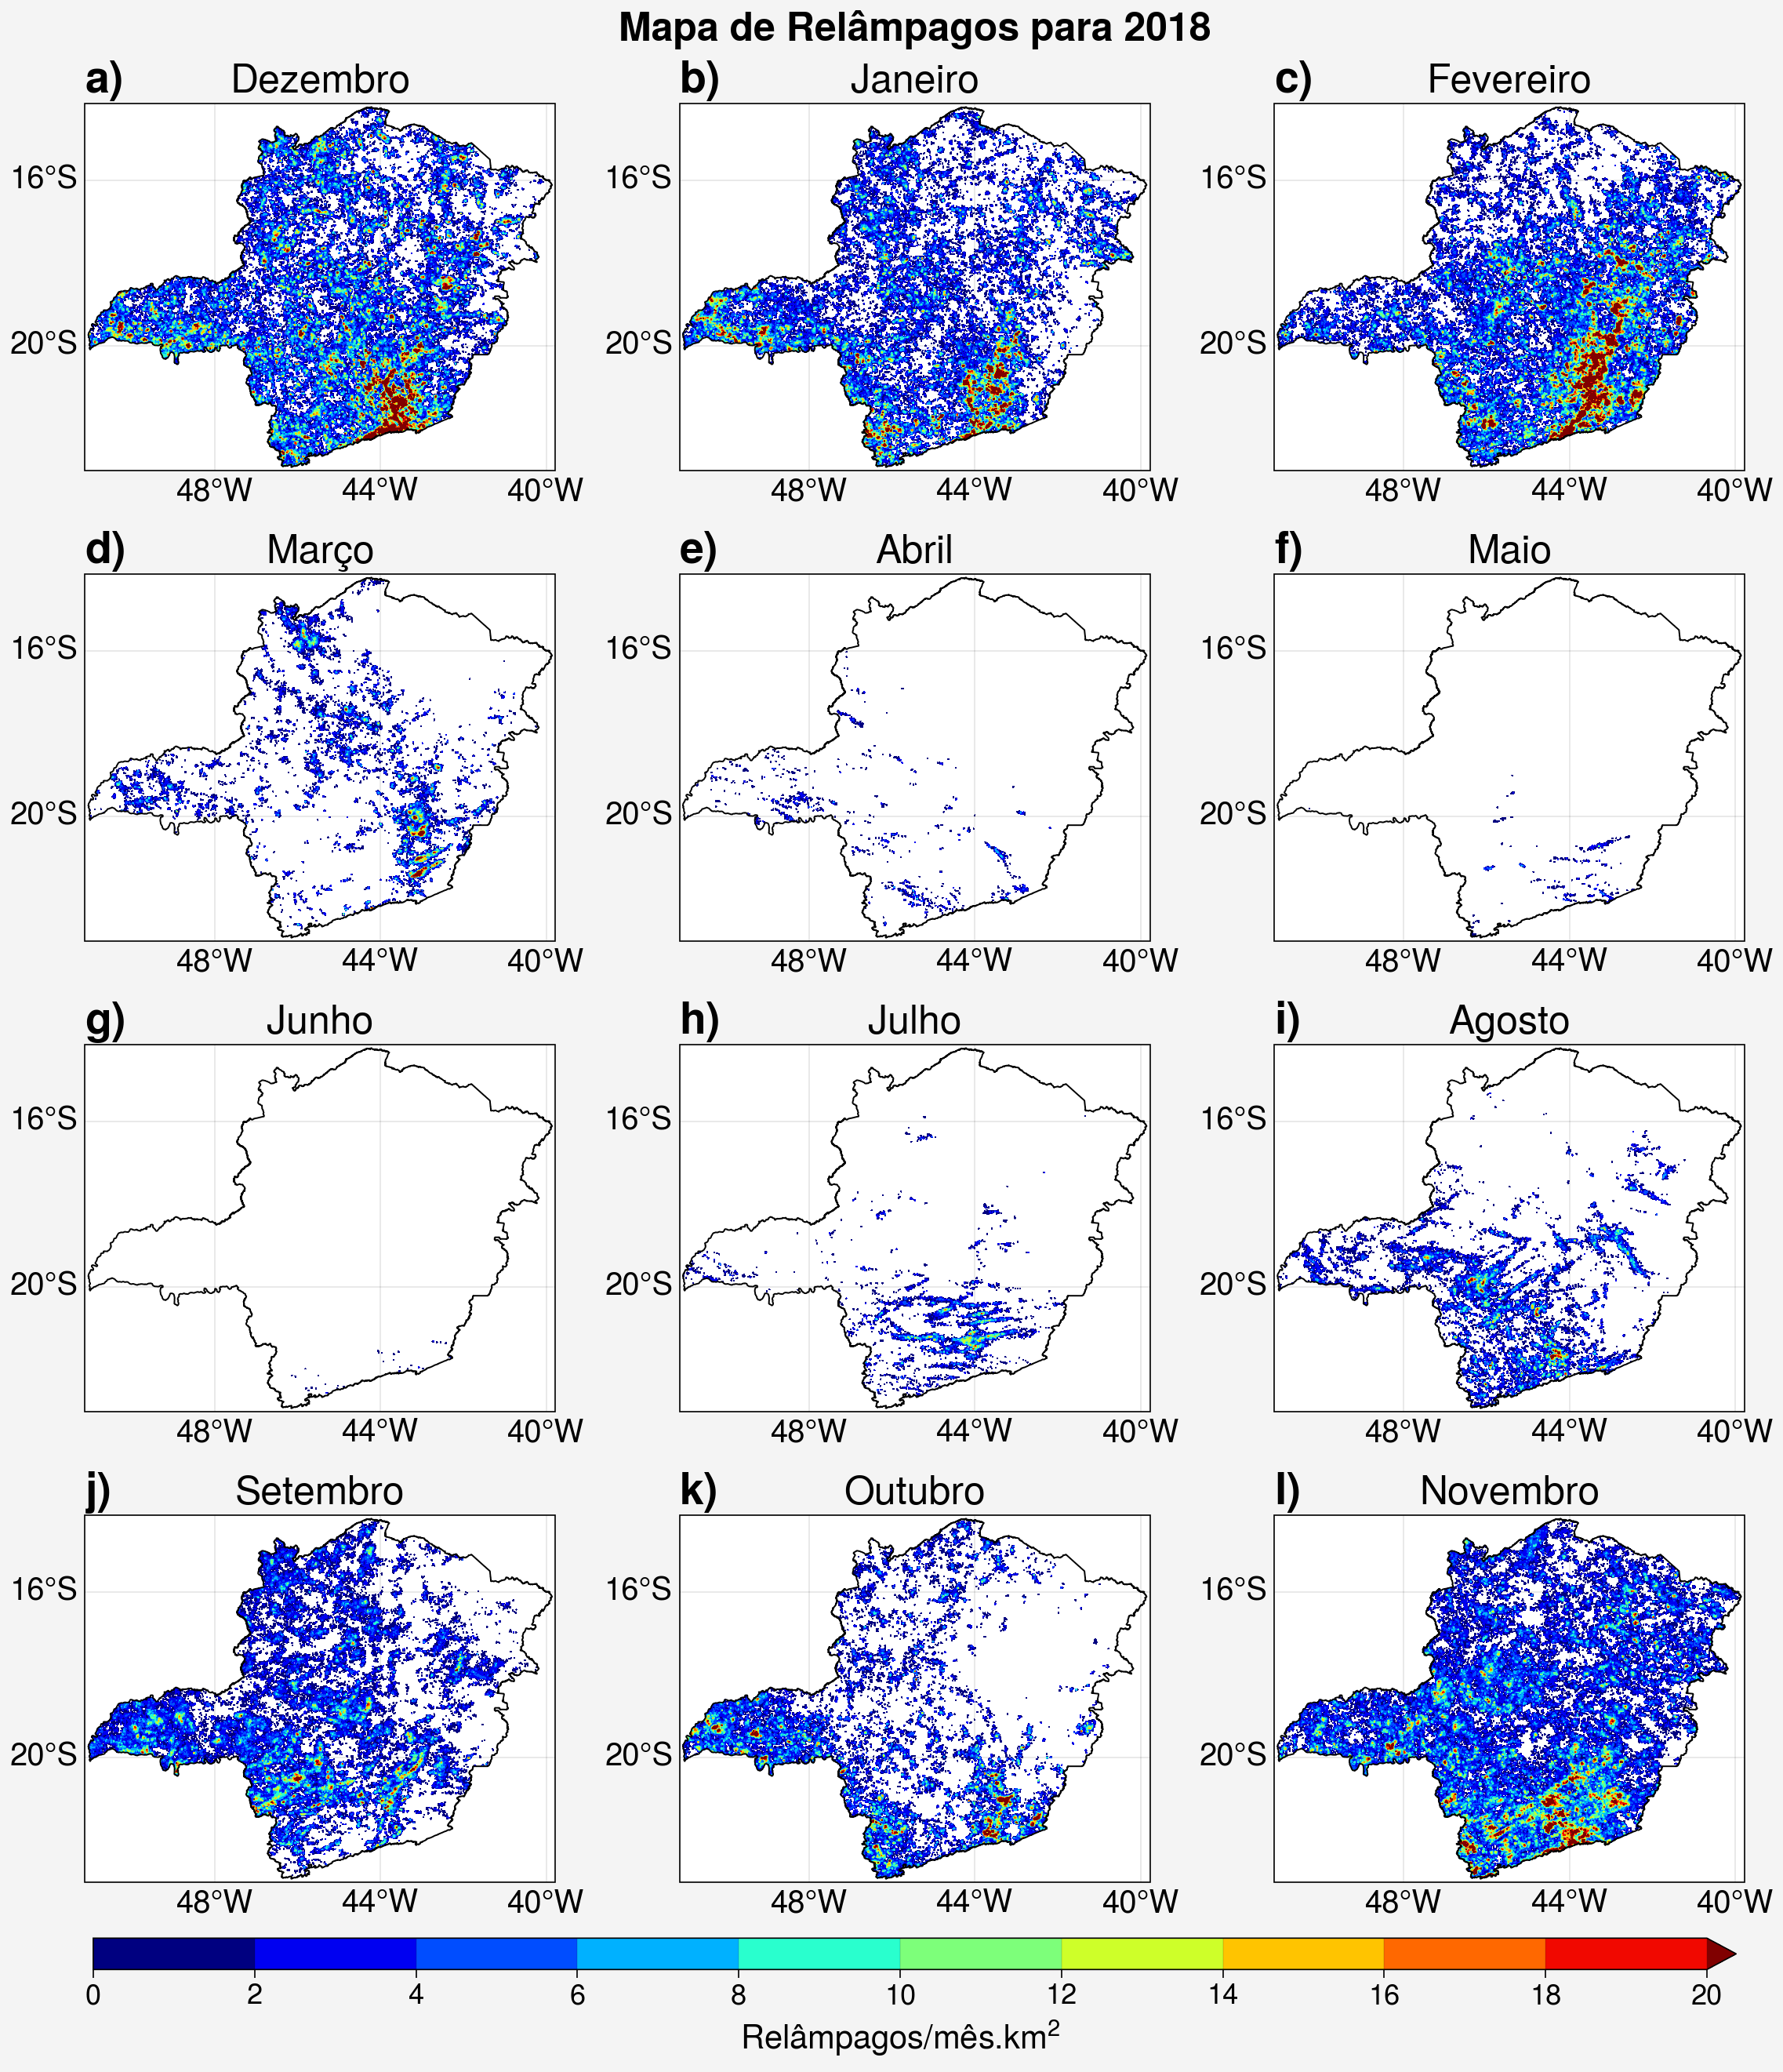

In [56]:
# cria a moldura da figura
fig, ax = uplt.subplots(axwidth=3, axheight=3, ncols=3, nrows=4, tight=True, proj='pcarree')

# formatação dos eixos
ax.format(coast=False, borders=False, innerborders=False,
          labels=True, latlines=4, lonlines=4,
          latlim=(latmin-0.08, latmax+0.08), lonlim=(lonmin-0.08, lonmax+0.08),
          suptitle=f'Mapa de Relâmpagos para 2018',
          small='20px', large='25px',
          abc=True, abcstyle='a)', abcsize=20)

# adiciona shapefile do estado
shapefile=list(shpreader.Reader(f'/content/{sigla_estado}_UF_2019.shp').geometries())
ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=0.7)

# substituir zeros por NaN na variável 'raio'
mensal['raio'] = mensal['raio'].where(mensal['raio'] != 0, np.nan)

# loop dos meses
for imes in range(0, 12):

  print(f'Processando o mês: .... {imes}')

  # aplica mascara recortando o Estado no arquivo
  xr_shp = mensal['raio'][imes,:,:].salem.roi(shape=estado)

  # plota figura
  map1 = ax[imes].contourf(mensal['lon'],
                           mensal['lat'],
                           xr_shp,
                           cmap='jet',
                           vmin=0,
                           vmax=20,
                           levels=uplt.arange(0, 20, 2),
                           extend='max')

        #ax[0]...
        #ax[1]...
        #ax[12]...

  # plota titulo de cada figura
  ax[imes].format(title=nome_meses[imes-1])

# plota barra de cores da figura
fig.colorbar(map1, loc='b', label='Relâmpagos/mês.km$^{2}$', length=0.99, ticklabelsize=13, labelsize=15)

# salva figura
fig.save(f'{dir}/output/Fig_3_relampagos_total_mensal_{sigla_estado}.jpg', dpi=300)

# exibe na tela
uplt.show()

#**PARTE 7:** Salvando a quantidade de relâmpagos mensal para um **arquivo ASCII**

**Contabiliza os relâmpagos para cada mês**

In [35]:
nome_mes = []
raios_mes = []

# Loop dos meses
for imes in range(0, 12):

    # nome do mês
    mes = calendar.month_name[int(imes+1)]

    # junta o nome dos meses numa lista
    nome_mes.append(mes)

    print('Processando --->>>', mes)

    # contabiliza os relâmpagos dentro do Estado escolhido
    raios = float(mensal['raio'][imes,:,:].salem.roi(shape=estado).sum(dim=('lon','lat')).values)

    #raios = 200
    #raios = 500

    # junta o valor da quantidade de relâmpagos numa lista
    raios_mes.append(raios)

    # raios_mes.append(200, 500...)

Processando --->>> January
Processando --->>> February
Processando --->>> March
Processando --->>> April
Processando --->>> May
Processando --->>> June
Processando --->>> July
Processando --->>> August
Processando --->>> September
Processando --->>> October
Processando --->>> November
Processando --->>> December


**Salva num arquivo**

In [36]:
with open(f'{dir}/output/raios_{sigla_estado}.txt', 'w') as arquivo:
    for imes, iraios in zip(nome_mes, raios_mes):
        arquivo.write(f'{imes} {iraios} \n')
        print(f'{imes} {iraios}')

January 875820.0
February 584214.0
March 918568.0
April 119401.0
May 12779.0
June 4109.0
July 970.0
August 46725.0
September 141411.0
October 409065.0
November 282491.0
December 807641.0
